In [1]:
import pandas as pd
import nltk
import psycopg2 as pg
import psycopg2.extras
import re
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


- ak CALC_SENTIMENT_SCORES = True, vypočíta sa sentiment pomocou VADER lexikónu a uloží do databázy 
- ak ADD_CONSPIRACY_THEORY_LIST_TO_DB = True, conspiracy_theory_list sa uloží do databázy 
- ak ADD_TWEET_CONSPIRACY_THEORY_LIST_TO_DB = True, uloží sa do databázy mapovanie tweetov na konšpiračné teórie 

In [2]:
CALC_SENTIMENT_SCORES = False
ADD_CONSPIRACY_THEORY_LIST_TO_DB = False
ADD_TWEET_CONSPIRACY_THEORY_LIST_TO_DB = False

## Konfigurácia PostgreSQL databázy

In [3]:
def get_db_connection():
    return pg.connect(
        host="localhost",
        database="pdt_tweets_backup",
        user="postgres",
        password="")    

In [4]:
def create_tables():
    commands = (
        """
        CREATE TABLE IF NOT EXISTS conspiracy_theories (
            id SERIAL PRIMARY KEY,
            value VARCHAR NOT NULL
        )
        """,
        
        """
        CREATE TABLE IF NOT EXISTS tweet_conspiracy_theories (
            id SERIAL PRIMARY KEY,
            tweet_id VARCHAR(20) NOT NULL,
            conspiracy_theory_id INTEGER NOT NULL,
            FOREIGN KEY (tweet_id)
                REFERENCES tweets (id)
                ON UPDATE CASCADE ON DELETE RESTRICT,
            FOREIGN KEY (conspiracy_theory_id)
                REFERENCES conspiracy_theories (id)
                ON UPDATE CASCADE ON DELETE RESTRICT
        )
        """,
        
        """
        ALTER TABLE tweets 
            ADD COLUMN IF NOT EXISTS negative NUMERIC(6, 4),
            ADD COLUMN IF NOT EXISTS neutral NUMERIC(6, 4),
            ADD COLUMN IF NOT EXISTS positive NUMERIC(6, 4),
            ADD COLUMN IF NOT EXISTS compound NUMERIC(6, 4)
        """
    )
    
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        
        for command in commands:
            cur.execute(command)
            
        cur.close()
        conn.commit()
    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
     
    
create_tables()

## 2. Úloha
Vypočítajte sentiment pomocou VADER lexikónu pre
tweety, ktoré obsahujú konšpiračné hashtagy.

In [5]:
def get_conspiracy_tweets():
    sql = """
    SELECT DISTINCT tweets.id AS tweet_id, tweets.content AS tweet
    FROM tweets 
    INNER JOIN tweet_hashtags ON tweets.id = tweet_hashtags.tweet_id  
    INNER JOIN hashtags ON hashtags.id = tweet_hashtags.hashtag_id
    WHERE hashtags.value ILIKE ANY(ARRAY[
                        '%DeepstateVirus%',
                        '%DeepStateVaccine%',
                        '%DeepStateFauci%',
                        '%QAnon%',
                        '%Agenda21%',
                        '%CCPVirus%',
                        '%ClimateChangeHoax%',
                        '%GlobalWarmingHoax%',
                        '%ChinaLiedPeopleDied%',
                        '%SorosVirus%',
                        '%5GCoronavirus%',
                        '%MAGA%',
                        '%WWG1WGA%',
                        '%Chemtrails%',
                        '%flatEarth%',
                        '%MoonLandingHoax%',
                        '%moonhoax%',
                        '%illuminati%',
                        '%pizzaGateIsReal%',
                        '%PedoGateIsReal%',
                        '%911truth%',
                        '%911insidejob%',
                        '%reptilians%'
                    ])
    """

    conn = get_db_connection()
    df = pd.read_sql(sql, con=conn)
    conn.close()
    return df


tweets_df = get_conspiracy_tweets()
tweets_df

,tweet_id,tweet
0,1034289685227614208,#TrueMAGA〽️🦅\nPEDOPHILIA IS AN EPIDEMIC IN USA...
1,1037494012033343488,#TrueMAGA 〽️🦅\nPEDOPHILIA ‘EPIDEMIC’ WORLD-UNT...
2,1038674252940148736,"#USA and #India, Wary of @china, Agree to Stre..."
3,1039279051456831489,#TrueMAGA〽️🦅\nCOMMUNlST CHlNA CENSORSHIP IN AM...
4,1039284206856286208,#TrueMAGA〽️🦅\nChina owns our dept. The Chinese...
...,...,...
2152419,984572021303664640,#TrueMAGA 〽️🦅\nPedophilia Epidemic World: \n\n...
2152420,986043842603507712,#TrueMAGA 〽️🦅\n#PedogateisReal \n#BringDownThe...
2152421,988105922831667200,#TrueMAGA 〽️🦅\nCHILD TRAFFICKING: \n\nRoughly ...
2152422,997954448407351296,But but but...CNN said trade wars and economic...


Odstránenie emotikonov, hashtagov a mentionov z tweetov.

In [6]:
# zdroj https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_hashtags_and_mentions(text):
    return re.sub(r'(^|(\s))(#|@)\w+', r'\1', text)


def get_cleaned_tweets(tweets_df):
    tweets_df['tweet'] = tweets_df['tweet'].apply(lambda tweet: remove_emoji(tweet))
    tweets_df['tweet'] = tweets_df['tweet'].apply(lambda tweet: remove_hashtags_and_mentions(tweet))
    return tweets_df


tweets_df = get_cleaned_tweets(tweets_df)

Vypočítanie sentimentu pomocou VADER lexikónu.

In [7]:
def calc_tweet_sentiment_scores(tweets_df):
    sid = SentimentIntensityAnalyzer()
    tweets_df['scores'] = tweets_df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
    tweets_df['negative'] = tweets_df['scores'].apply(lambda score_dict: score_dict['neg'])
    tweets_df['neutral'] = tweets_df['scores'].apply(lambda score_dict: score_dict['neu'])
    tweets_df['positive'] = tweets_df['scores'].apply(lambda score_dict: score_dict['pos'])
    tweets_df['compound'] = tweets_df['scores'].apply(lambda score_dict: score_dict['compound'])
    tweets_df = tweets_df.drop(columns='scores')
    return tweets_df


def update_tweet_sentiment_scores(tweets_df):
    sentiment_scores_list = [tuple(r) for r in tweets_df[['tweet_id', 'negative', 'neutral', 
                                                          'positive', 'compound']].to_numpy()]
    sql = """
    UPDATE tweets SET 
    negative = upt.negative,
    neutral = upt.neutral,
    positive = upt.positive,
    compound = upt.compound
    FROM (VALUES %s) AS upt (tweet_id, negative, neutral, positive, compound) 
    WHERE tweets.id = upt.tweet_id
    """
    
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        psycopg2.extras.execute_values(cur, sql, sentiment_scores_list)
        conn.commit()
        cur.close()
    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()


if (CALC_SENTIMENT_SCORES):
    tweets_df = calc_tweet_sentiment_scores(tweets_df)
    update_tweet_sentiment_scores(tweets_df)

## 3. Úloha
Roztrieďte vyfiltrované tweety z predošlého zadania medzi konšpiračné teórie –
spravte si na to novú tabuľku a mapovanie – nech je jasné ktorý tweet patrí ktorej
konšpiračnej teórii.

In [8]:
def insert_conspiracy_theory_list(conspiracy_theory_list):
    sql = 'INSERT INTO conspiracy_theories(value) VALUES(%s)'
    
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        cur.executemany(sql, conspiracy_theory_list)
        conn.commit()
        cur.close()
    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    
    
conspiracy_theory_list = [
    ('Deep State',),
    ('Qanon',),
    ('New world order',),
    ('The virus escaped from a Chinese lab',),
    ('GLobal Warming is HOAX',),
    ('COVID19 and microchipping',),
    ('COVID19 is preaded by 5G',),
    ('Moon landing is fake',),
    ('9/11 was inside job',),
    ('Pizzagate conspiracy theory',),
    ('Chemtrails',),
    ('FlatEarth',),
    ('Illuminati',),
    ('Reptilian conspiracy theory',)
]

if (ADD_CONSPIRACY_THEORY_LIST_TO_DB):
    insert_conspiracy_theory_list(conspiracy_theory_list)

In [9]:
def insert_tweet_conspiracy_theory():
    sql = """
    INSERT INTO tweet_conspiracy_theories(tweet_id, conspiracy_theory_id)
    SELECT DISTINCT t1.tweet_id, t1.conspiracy_theory_id FROM (
        SELECT tweets.id AS tweet_id, CASE 
        WHEN hashtags.value ILIKE ANY(ARRAY['%DeepstateVirus%', '%DeepStateVaccine%', '%DeepStateFauci%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Deep State')
        WHEN hashtags.value ILIKE ANY(ARRAY['%QAnon%', '%MAGA%', '%WWG1WGA%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Qanon')
        WHEN hashtags.value ILIKE ANY(ARRAY['%Agenda21%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'New world order')
        WHEN hashtags.value ILIKE ANY(ARRAY['%CCPVirus%', '%ChinaLiedPeopleDied%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'The virus escaped from a Chinese lab')
        WHEN hashtags.value ILIKE ANY(ARRAY['%ClimateChangeHoax%', '%GlobalWarmingHoax%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'GLobal Warming is HOAX')
        WHEN hashtags.value ILIKE ANY(ARRAY['%SorosVirus%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'COVID19 and microchipping')	
        WHEN hashtags.value ILIKE ANY(ARRAY['%5GCoronavirus%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'COVID19 is preaded by 5G')
        WHEN hashtags.value ILIKE ANY(ARRAY['%MoonLandingHoax%', '%moonhoax%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Moon landing is fake')
        WHEN hashtags.value ILIKE ANY(ARRAY['%911truth%', '%911insidejob%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = '9/11 was inside job')
        WHEN hashtags.value ILIKE ANY(ARRAY['%pizzaGateIsReal%', '%PedoGateIsReal%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Pizzagate conspiracy theory')
        WHEN hashtags.value ILIKE ANY(ARRAY['%Chemtrails%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Chemtrails')
        WHEN hashtags.value ILIKE ANY(ARRAY['%flatEarth%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'FlatEarth')
        WHEN hashtags.value ILIKE ANY(ARRAY['%illuminati%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Illuminati')
        WHEN hashtags.value ILIKE ANY(ARRAY['%reptilians%']) 
            THEN (SELECT id FROM conspiracy_theories WHERE value = 'Reptilian conspiracy theory')
        END AS conspiracy_theory_id 
        FROM tweets
        INNER JOIN tweet_hashtags ON tweets.id = tweet_hashtags.tweet_id 
        INNER JOIN hashtags ON hashtags.id = tweet_hashtags.hashtag_id
        WHERE tweets.compound IS NOT NULL
    ) AS t1
    WHERE t1.conspiracy_theory_id IS NOT NULL
    """
    
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        cur.execute(sql)
        conn.commit()
        cur.close()
    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
                
                        
if (ADD_TWEET_CONSPIRACY_THEORY_LIST_TO_DB):
    insert_tweet_conspiracy_theory()

## 4. Úloha
Vypočítajte pomer extrémnych a neutrálnych sentimentov tweetov pre konšpiračné
teórie po týždňoch a zistite, či daná konšpiračná teória rastie alebo upadá v čase.
Výstup vizualizujte v grafe. Rovnako uveďte aj absolútne čísla: tweet_count,
tweet_extreme_count, tweet_neutral_count v tabuľke pre každý týždeň. Za extrém
považujeme keď je compound väčší ako 0,5 alebo menší ako -0,5.

In [10]:
def get_weekly_conspiracy(start_date, end_date):
    sql = """
    SELECT t1.trunc_week_series AS week_series, t2.conspiracy_theory, COALESCE(t2.t_count, 0) AS tweet_count, 
        COALESCE(t2.t_ext_count, 0) AS tweet_extreme_count, COALESCE(t2.t_neu_count, 0) AS tweet_neutral_count
    FROM (
        SELECT DATE_TRUNC('week', week_series) AS trunc_week_series FROM 
        generate_series(%(start_date)s::DATE, %(end_date)s::DATE, '1 week'::interval) AS week_series
    ) t1
    LEFT JOIN (
        SELECT DATE_TRUNC('week', happened_at) AS trunc_week_series, conspiracy_theories.value AS conspiracy_theory,
        COUNT(*) AS t_count,
        COUNT(*) FILTER (WHERE (compound < -0.5) OR (compound > 0.5)) AS t_ext_count, 
        COUNT(*) FILTER (WHERE (compound >= -0.5) AND (compound <= 0.5)) AS t_neu_count 
        FROM tweets
        INNER JOIN tweet_conspiracy_theories ON tweets.id = tweet_conspiracy_theories.tweet_id
        INNER JOIN conspiracy_theories ON conspiracy_theories.id = tweet_conspiracy_theories.conspiracy_theory_id
        GROUP BY trunc_week_series, conspiracy_theories.id
    ) t2 ON t1.trunc_week_series = t2.trunc_week_series
    ORDER BY t1.trunc_week_series 
    """
    
    conn = get_db_connection()
    weekly_conspiracy_df = pd.read_sql(sql, con=conn, params={'start_date': start_date, 'end_date': end_date})
    conn.close()
    return weekly_conspiracy_df


weekly_conspiracy_df = get_weekly_conspiracy('2006-05-06 01:10:21+00', '2020-05-29 13:37:26+00')
weekly_conspiracy_df

,week_series,conspiracy_theory,tweet_count,tweet_extreme_count,tweet_neutral_count
0,2006-05-01 00:00:00+00:00,None,0,0,0
1,2006-05-08 00:00:00+00:00,None,0,0,0
2,2006-05-15 00:00:00+00:00,None,0,0,0
3,2006-05-22 00:00:00+00:00,None,0,0,0
4,2006-05-29 00:00:00+00:00,None,0,0,0
...,...,...,...,...,...
874,2020-05-18 00:00:00+00:00,9/11 was inside job,7,0,7
875,2020-05-18 00:00:00+00:00,Pizzagate conspiracy theory,261,61,200
876,2020-05-18 00:00:00+00:00,Chemtrails,29,24,5
877,2020-05-18 00:00:00+00:00,FlatEarth,64,16,48


In [11]:
# df_theory_1 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Deep State']
# df_theory_2 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Qanon']
# df_theory_3 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'New world order']
# df_theory_4 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'The virus escaped from a Chinese lab']
# df_theory_5 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'GLobal Warming is HOAX']
# df_theory_6 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'COVID19 and microchipping']
# df_theory_7 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'COVID19 is preaded by 5G']
# df_theory_8 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Moon landing is fake']
# df_theory_9 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == '9/11 was inside job']
# df_theory_10 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Pizzagate conspiracy theory']
# df_theory_11 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Chemtrails']
# df_theory_12 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'FlatEarth']
# df_theory_13 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Illuminati']
# df_theory_14 = weekly_conspiracy_df[weekly_conspiracy_df['conspiracy_theory'] == 'Reptilian conspiracy theory']

In [12]:
# df_theory_1.to_csv('theories/theory_1.csv', encoding='utf-8', index=False)
# df_theory_2.to_csv('theories/theory_2.csv', encoding='utf-8', index=False)
# df_theory_3.to_csv('theories/theory_3.csv', encoding='utf-8', index=False)
# df_theory_4.to_csv('theories/theory_4.csv', encoding='utf-8', index=False)
# df_theory_5.to_csv('theories/theory_5.csv', encoding='utf-8', index=False)
# df_theory_6.to_csv('theories/theory_6.csv', encoding='utf-8', index=False)
# df_theory_7.to_csv('theories/theory_7.csv', encoding='utf-8', index=False)
# df_theory_8.to_csv('theories/theory_8.csv', encoding='utf-8', index=False)
# df_theory_9.to_csv('theories/theory_9.csv', encoding='utf-8', index=False)
# df_theory_10.to_csv('theories/theory_10.csv', encoding='utf-8', index=False)
# df_theory_11.to_csv('theories/theory_11.csv', encoding='utf-8', index=False)
# df_theory_12.to_csv('theories/theory_12.csv', encoding='utf-8', index=False)
# df_theory_13.to_csv('theories/theory_13.csv', encoding='utf-8', index=False)
# df_theory_14.to_csv('theories/theory_14.csv', encoding='utf-8', index=False)

In [13]:
def plot_weekly_conspiracy(weekly_conspiracy_df, conspiracy=None):
    if conspiracy:
        selected_weekly_conspiracy_df = weekly_conspiracy_df.loc[weekly_conspiracy_df['conspiracy_theory'] == conspiracy]
    else:
        selected_weekly_conspiracy_df = weekly_conspiracy_df
        
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.autofmt_xdate() 
    if conspiracy:
        plt.title(conspiracy, fontsize=18)
    plt.xlabel('Date')
    plt.ylabel('Tweet count')
    ax.plot(selected_weekly_conspiracy_df['week_series'], selected_weekly_conspiracy_df['tweet_count'])
    # plt.savefig('images/' + conspiracy.replace("/", "_") + '.jpg', bbox_inches='tight')

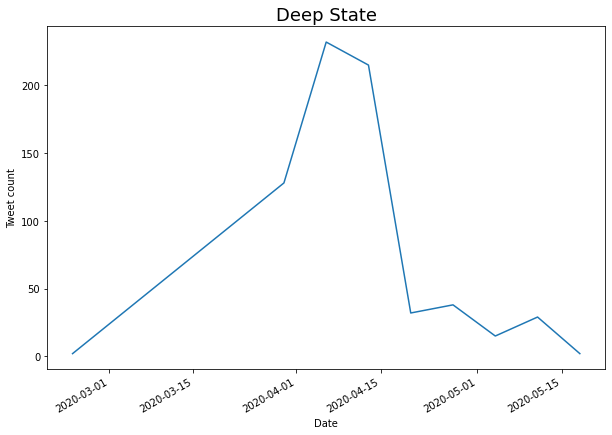

In [14]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Deep State')

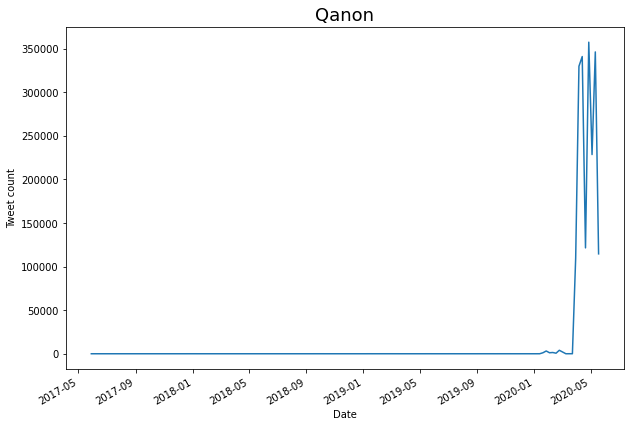

In [15]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Qanon')

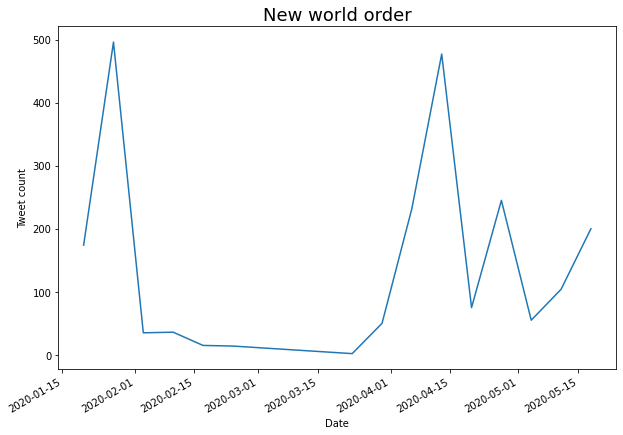

In [16]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'New world order')

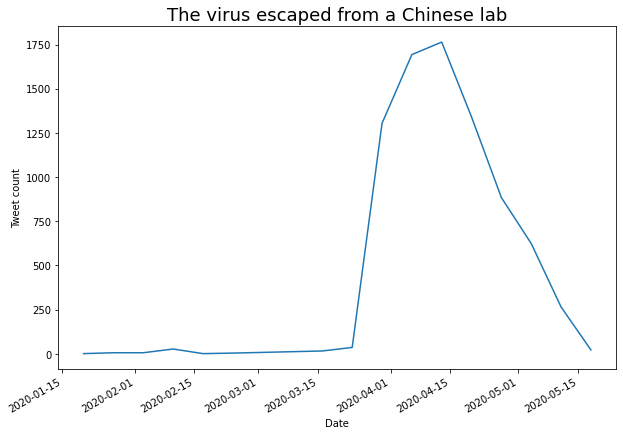

In [17]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'The virus escaped from a Chinese lab')

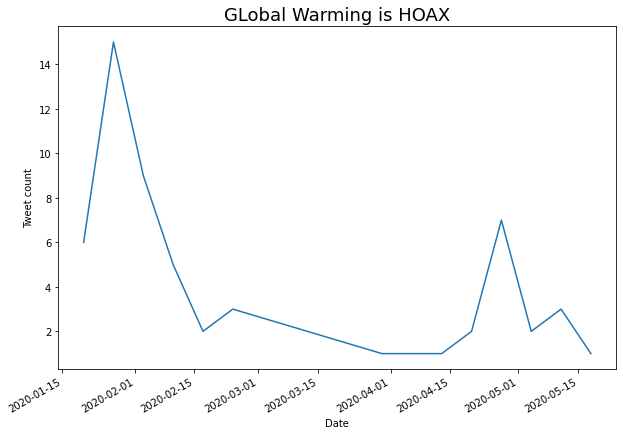

In [18]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'GLobal Warming is HOAX')

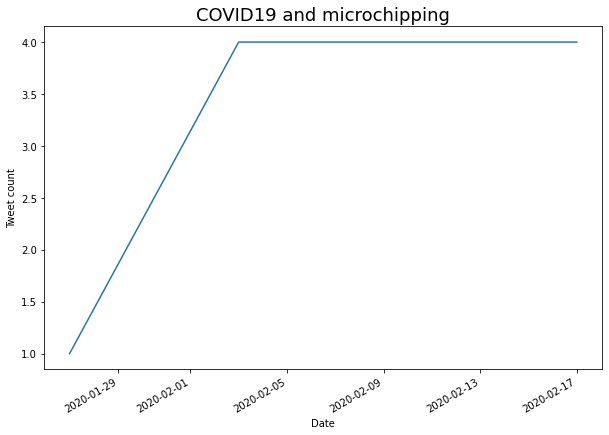

In [19]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'COVID19 and microchipping')

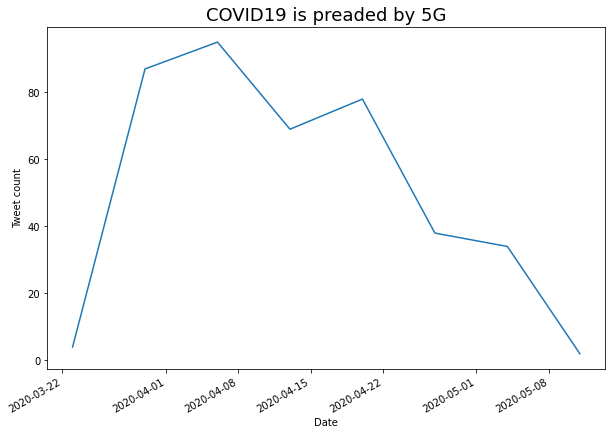

In [20]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'COVID19 is preaded by 5G')

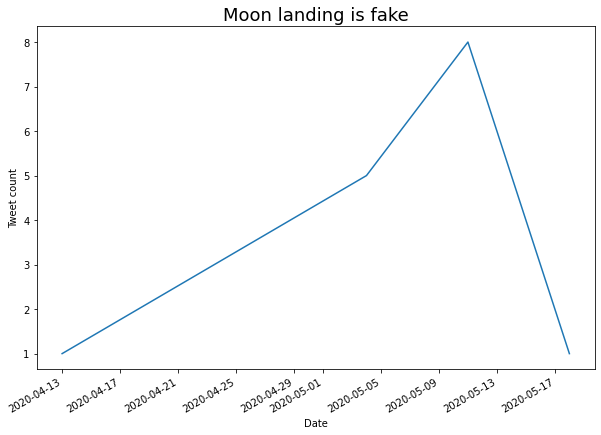

In [21]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Moon landing is fake')

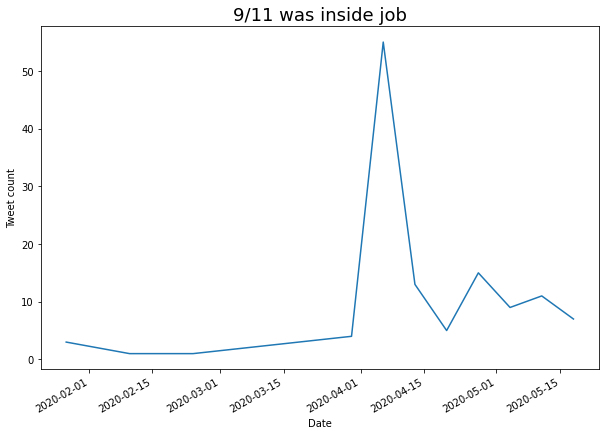

In [22]:
plot_weekly_conspiracy(weekly_conspiracy_df, '9/11 was inside job')

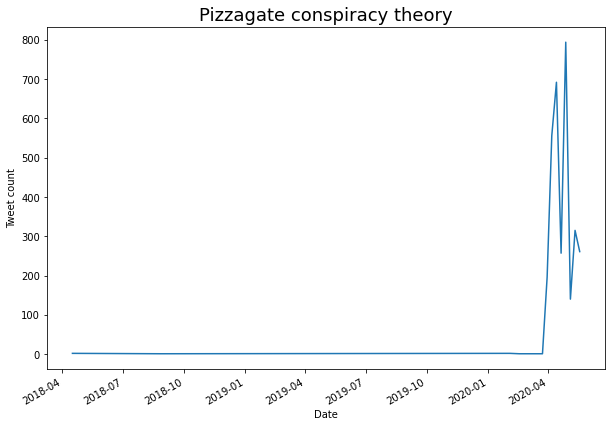

In [23]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Pizzagate conspiracy theory')

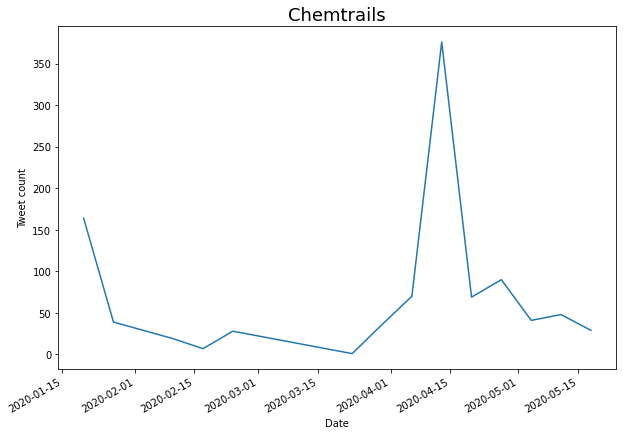

In [24]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Chemtrails')

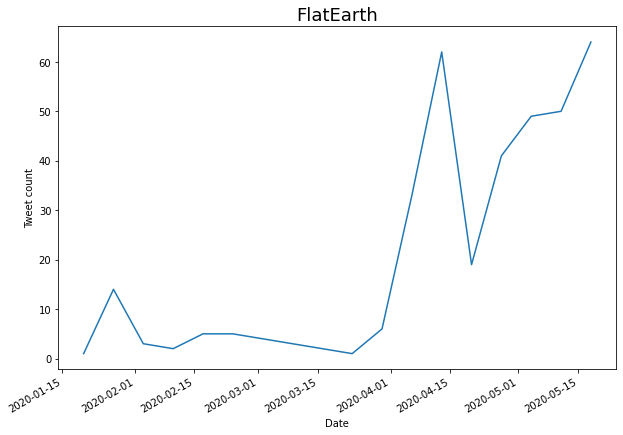

In [25]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'FlatEarth')

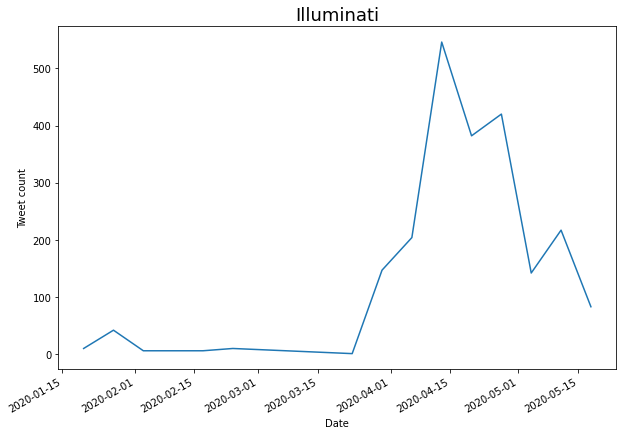

In [26]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Illuminati')

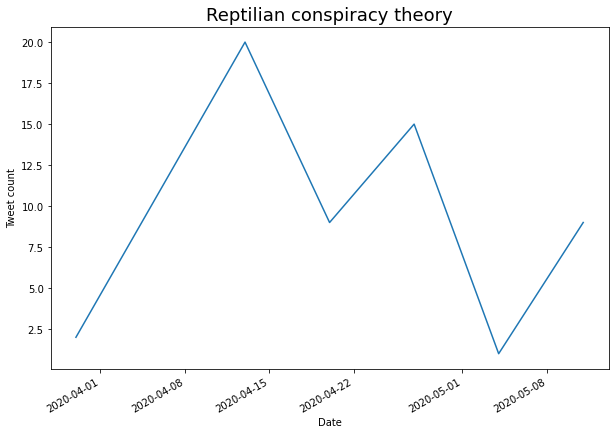

In [27]:
plot_weekly_conspiracy(weekly_conspiracy_df, 'Reptilian conspiracy theory')

Uveďte aj absolútne čísla: tweet_count,
tweet_extreme_count, tweet_neutral_count v tabuľke pre každý týždeň.

In [28]:
def get_aggregated_weekly_conspiracy(start_date, end_date):
    sql = """
    SELECT t1.trunc_week_series AS week_series, COALESCE(t2.t_count, 0) AS tweet_count, 
        COALESCE(t2.t_ext_count, 0) AS tweet_extreme_count, COALESCE(t2.t_neu_count, 0) AS tweet_neutral_count
    FROM (
        SELECT DATE_TRUNC('week', week_series) AS trunc_week_series FROM 
        generate_series(%(start_date)s::DATE, %(end_date)s::DATE, '1 week'::interval) AS week_series
    ) t1
    LEFT JOIN (	
        SELECT DATE_TRUNC('week', happened_at) AS trunc_week_series,
        COUNT(*) AS t_count,
        COUNT(*) FILTER (WHERE (compound < -0.5) OR (compound > 0.5)) AS t_ext_count, 
        COUNT(*) FILTER (WHERE (compound >= -0.5) AND (compound <= 0.5)) AS t_neu_count 
        FROM tweets
        WHERE tweets.id IN (SELECT tweet_id FROM tweet_conspiracy_theories)
        GROUP BY trunc_week_series
    ) t2 ON t1.trunc_week_series = t2.trunc_week_series
    ORDER BY t1.trunc_week_series   
    """
    
    conn = get_db_connection()
    aggregated_weekly_conspiracy_df = pd.read_sql(sql, con=conn, params={'start_date': start_date, 'end_date': end_date})
    conn.close()
    return aggregated_weekly_conspiracy_df


aggregated_weekly_conspiracy_df = get_aggregated_weekly_conspiracy('2006-05-06 01:10:21+00', '2020-05-29 13:37:26+00')
aggregated_weekly_conspiracy_df

,week_series,tweet_count,tweet_extreme_count,tweet_neutral_count
0,2006-05-01 00:00:00+00:00,0,0,0
1,2006-05-08 00:00:00+00:00,0,0,0
2,2006-05-15 00:00:00+00:00,0,0,0
3,2006-05-22 00:00:00+00:00,0,0,0
4,2006-05-29 00:00:00+00:00,0,0,0
...,...,...,...,...
729,2020-04-20 00:00:00+00:00,122679,36974,85705
730,2020-04-27 00:00:00+00:00,357991,101674,256317
731,2020-05-04 00:00:00+00:00,229082,62732,166350
732,2020-05-11 00:00:00+00:00,346315,95552,250763


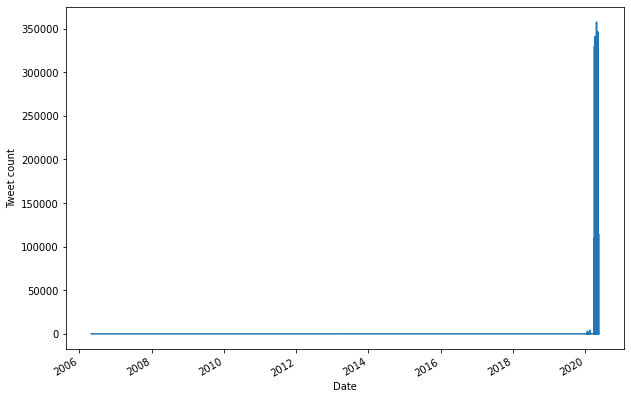

In [29]:
plot_weekly_conspiracy(weekly_conspiracy_df)

## 5. Úloha
Nájdite TOP10 account-ov ktoré sú najaktívnejšie v každej konšpiračnej teórii
s extrémnym sentimentom.

In [30]:
def get_top_10_conspiracy_accounts():
    sql = """
    SELECT conspiracy_theory_id, conspiracy_theory, account_id, name, 
        screen_name, tweet_extreme_count FROM
    (
        SELECT conspiracy_theory_id, conspiracy_theory, account_id, name, 
        screen_name, tweet_extreme_count, 
        ROW_NUMBER() OVER (PARTITION BY conspiracy_theory_id ORDER BY tweet_extreme_count DESC) AS r_n
        FROM
        (
            SELECT conspiracy_theories.id AS conspiracy_theory_id, conspiracy_theories.value AS conspiracy_theory,
            accounts.id AS account_id, accounts.name, accounts.screen_name, COUNT(*) AS tweet_extreme_count 
            FROM tweets  
            INNER JOIN tweet_conspiracy_theories ON tweets.id = tweet_conspiracy_theories.tweet_id
            INNER JOIN conspiracy_theories ON conspiracy_theories.id = tweet_conspiracy_theories.conspiracy_theory_id
            INNER JOIN accounts ON accounts.id = tweets.author_id
            WHERE (compound < -0.5) OR (compound > 0.5)
            GROUP BY conspiracy_theories.id, accounts.id
        ) t1
    ) t2
    WHERE r_n <= 10
    ORDER BY conspiracy_theory_id ASC, tweet_extreme_count DESC, account_id ASC
    """

    conn = get_db_connection()
    top_10_conspiracy_accounts_df = pd.read_sql(sql, con=conn)
    conn.close()
    return top_10_conspiracy_accounts_df


top_10_conspiracy_accounts_df = get_top_10_conspiracy_accounts()

with pd.option_context("display.max_rows", None):
    display(top_10_conspiracy_accounts_df)

,conspiracy_theory_id,conspiracy_theory,account_id,name,screen_name,tweet_extreme_count
0,1,Deep State,488615658,Manuela Forster,manuelaforster,17
1,1,Deep State,1001913640835059713,Dawn Trump's Girl!,DawnBar50941758,2
2,1,Deep State,1241657462564032512,Truth seeker Italia,Truthseekerita,2
3,1,Deep State,175828319,Anon60,Anon_60Anon,1
4,1,Deep State,885802506,Patrick,Sqeaksdad,1
5,1,Deep State,3115716289,Leo M.,rightwingleo2,1
6,1,Deep State,947637714060529664,OracoloQuantico⭐⭐⭐,432wps,1
7,1,Deep State,1090445315663048704,PatriAnon,AnonPatri,1
8,1,Deep State,1113904022208040967,Tizio.8020,8020Tizio,1
9,1,Deep State,1246839864357785602,WakeTheSheep!,WakeSheep,1


## 6. Úloha
Nájdite TOP10 najčastejšie používaných hashtagov pre každú konšpiračnú teóriu
z tweetov s extrémnym sentimentom.

In [31]:
def get_top_10_conspiracy_hashtags():
    sql = """
    SELECT conspiracy_theory_id, conspiracy_theory, hashtag_id, hashtag, tweet_extreme_count 
    FROM
    (
        SELECT conspiracy_theory_id, conspiracy_theory, hashtag_id, hashtag, tweet_extreme_count,
            ROW_NUMBER() OVER (PARTITION BY conspiracy_theory_id ORDER BY tweet_extreme_count DESC) AS r_n
        FROM
        (
            SELECT conspiracy_theories.id AS conspiracy_theory_id, conspiracy_theories.value AS conspiracy_theory, 
            hashtags.id AS hashtag_id, hashtags.value AS hashtag, COUNT(*) AS tweet_extreme_count 
            FROM tweets  
            INNER JOIN tweet_conspiracy_theories ON tweets.id = tweet_conspiracy_theories.tweet_id
            INNER JOIN conspiracy_theories ON conspiracy_theories.id = conspiracy_theory_id
            INNER JOIN tweet_hashtags ON tweets.id = tweet_hashtags.tweet_id
            INNER JOIN hashtags ON hashtags.id = tweet_hashtags.hashtag_id
            WHERE (compound < -0.5) OR (compound > 0.5)
            GROUP BY conspiracy_theories.id, hashtags.id
        ) t1
    ) t2
    WHERE r_n <= 10
    ORDER BY conspiracy_theory_id ASC, tweet_extreme_count DESC, hashtag_id ASC 
    """

    conn = get_db_connection()
    top_10_conspiracy_hashtags_df = pd.read_sql(sql, con=conn)
    conn.close()
    return top_10_conspiracy_hashtags_df


top_10_conspiracy_hashtags_df = get_top_10_conspiracy_hashtags()

with pd.option_context("display.max_rows", None):
    display(top_10_conspiracy_hashtags_df)

,conspiracy_theory_id,conspiracy_theory,hashtag_id,hashtag,tweet_extreme_count
0,1,Deep State,16542067,DeepStateFauci,99
1,1,Deep State,77112,Qanon,66
2,1,Deep State,1537279,Fauci,64
3,1,Deep State,34705,RT,63
4,1,Deep State,20506,QAnon,49
5,1,Deep State,82851,TheGreatAwakening,46
6,1,Deep State,7074589,DeepStateVirus,46
7,1,Deep State,25091,qanon,33
8,1,Deep State,206162,COVID19,30
9,1,Deep State,511508,wwg1wga,30
